# Vorhersage des FDI-Ratings

Dieses Notebook baut auf der explorativen Analyse auf und entwickelt schrittweise Machine-Learning-Modelle, um das `profile_fdi_rating` zu prognostizieren.

## Vorgehensweise

- Daten laden und laut Projektvorgaben um engineered Features ergaenzen.
- Feature-Sets definieren und einen sauberen Train/Test-Split festlegen.
- Baseline via Mean-Predictor bestimmen und gegen ML-Modelle vergleichen.
- Modelle (Linear Regression -> Ridge/Lasso -> Random Forest) samt Cross-Validation bewerten.
- Bestes Modell diagnostizieren (Residuals, Feature-Importance) und dokumentieren.

In [49]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.base import clone

import joblib

plt.style.use("seaborn-v0_8")
sns.set_theme(context="notebook", style="whitegrid", palette="deep")
RANDOM_STATE = 42

In [50]:
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_PATH = PROJECT_ROOT / "data/processed/player_stats_all.csv"
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df["country"] = df["country_code"].fillna("UNK")
LEAKY_FEATURES = ["api_rank", "api_overall_stat"]
df = df.drop(columns=LEAKY_FEATURES, errors="ignore")

numeric_like_cols = [
    "age", "profile_total_earnings", "profile_9_darters", "profile_season_win_pct",
    "profile_tour_card_years", "profile_highest_average", "profile_order_of_merit",
    "profile_highest_tv_average", "last_12_months_averages", "last_12_months_first_9_averages",
    "last_12_months_first_3_averages", "last_12_months_with_throw_averages",
    "last_12_months_against_throw_averages", "last_12_months_highest_checkout",
    "last_12_months_checkout_pcnt", "last_12_months_functional_doubles_pcnt",
    "last_12_months_pcnt_legs_won", "last_12_months_pcnt_legs_won_throwing_first",
    "last_12_months_pcnt_legs_won_throwing_second", "last_12_months_180_s",
    "last_12_months_171_180_s", "last_12_months_140_s", "last_12_months_131_140_s",
    "api_sum_field1", "api_sum_field2", "profile_fdi_rating",
]
for col in numeric_like_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")


def _safe_ratio(numerator: pd.Series, denominator: pd.Series) -> pd.Series:
    denom = denominator.replace({0: np.nan})
    ratio = numerator / denom
    return ratio.replace([np.inf, -np.inf], np.nan)


# Erweiterte Feature-Generierung, um Scoring-, Checkout- und Erfahrungssignale zu kombinieren
df["log_total_earnings"] = np.log1p(df["profile_total_earnings"].clip(lower=0))
df["season_win_rate"] = df["profile_season_win_pct"] / 100
checkout_product = df["last_12_months_checkout_pcnt"] * df["last_12_months_functional_doubles_pcnt"]
df["checkout_combo"] = checkout_product / 100

df["first9_delta"] = df["last_12_months_first_9_averages"] - df["last_12_months_averages"]
df["momentum_gap"] = (
    df["last_12_months_with_throw_averages"] - df["last_12_months_against_throw_averages"]
)
experience_denom = df["age"].replace({0: np.nan})
df["experience_intensity"] = _safe_ratio(df["profile_tour_card_years"], experience_denom)

df["earnings_per_year"] = _safe_ratio(df["profile_total_earnings"], df["profile_tour_card_years"])
df["first9_ratio"] = _safe_ratio(
    df["last_12_months_first_9_averages"], df["last_12_months_averages"]
)
df["break_efficiency"] = _safe_ratio(
    df["last_12_months_pcnt_legs_won_throwing_second"],
    df["last_12_months_pcnt_legs_won_throwing_first"],
)
df["hold_break_spread"] = (
    df["last_12_months_pcnt_legs_won_throwing_first"]
    - df["last_12_months_pcnt_legs_won_throwing_second"]
)
power_numerator = df["last_12_months_180_s"] + df["last_12_months_171_180_s"]
power_denominator = df["last_12_months_140_s"] + df["last_12_months_131_140_s"]
df["power_scoring_ratio"] = _safe_ratio(power_numerator, power_denominator)
df["tv_stage_delta"] = df["profile_highest_tv_average"] - df["profile_highest_average"]

derived_feature_cols = [
    "log_total_earnings",
    "season_win_rate",
    "checkout_combo",
    "first9_delta",
    "momentum_gap",
    "experience_intensity",
    "earnings_per_year",
    "first9_ratio",
    "break_efficiency",
    "hold_break_spread",
    "power_scoring_ratio",
    "tv_stage_delta",
]
for col in derived_feature_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

target = "profile_fdi_rating"
model_df = df.dropna(subset=[target]).copy()
print(f"Beobachtungen fuer das Training: {len(model_df):,}")
model_df[[target, "log_total_earnings", "season_win_rate"]].describe().T

Beobachtungen fuer das Training: 2,477


,count,mean,std,min,25%,50%,75%,max
profile_fdi_rating,2477.0,1352.838514,183.413271,752.0,1228.00,1363.000000,1483.00000,1972.000000
log_total_earnings,2477.0,4.323655,4.363081,0.0,0.00,4.330733,7.71913,16.288454
season_win_rate,2477.0,0.475010,0.180141,0.0,0.36,0.500000,0.61000,1.000000


### Entfernte API-Features
Die von Darts Orakel gelieferten Spalten `api_rank` und `api_overall_stat` kodieren bereits das fertige FDI-Ranking bzw. eine daraus abgeleitete Gesamtkennzahl. Damit wuerden wir dem Modell Zielwissen einspeisen (Data Leakage). Beide Features werden daher direkt nach dem Laden entfernt und tauchen in keinem Trainings- oder Deployment-Schritt mehr auf.

## Feature-Setup und Split

Hard Facts (Averages, Checkout, 180er) werden mit Soft Facts (Win %, Ranglisten, Log-Earnings) kombiniert.

In [51]:
numeric_features = [
    "age", "profile_total_earnings", "log_total_earnings", "profile_9_darters",
    "profile_season_win_pct", "season_win_rate", "profile_tour_card_years",
    "profile_highest_average", "profile_highest_tv_average", "profile_order_of_merit",
    "last_12_months_averages", "last_12_months_first_9_averages", "first9_delta",
    "last_12_months_first_3_averages", "last_12_months_with_throw_averages",
    "last_12_months_against_throw_averages", "momentum_gap",
    "last_12_months_highest_checkout", "last_12_months_checkout_pcnt",
    "last_12_months_functional_doubles_pcnt", "checkout_combo",
    "last_12_months_pcnt_legs_won", "last_12_months_pcnt_legs_won_throwing_first",
    "last_12_months_pcnt_legs_won_throwing_second", "last_12_months_180_s",
    "last_12_months_171_180_s", "last_12_months_140_s", "last_12_months_131_140_s",
    "api_sum_field1", "api_sum_field2", "experience_intensity",
    "earnings_per_year", "first9_ratio", "break_efficiency", "hold_break_spread",
    "power_scoring_ratio", "tv_stage_delta",
]
categorical_features = ["country"]
feature_cols = numeric_features + categorical_features
missing_features = sorted(set(feature_cols) - set(model_df.columns))
if missing_features:
    raise ValueError(f"Missing features: {missing_features}")

X = model_df[feature_cols].copy()
y = model_df[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE,
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (1981, 38), Test: (496, 38)


## Baseline-Benchmark

In [52]:
baseline_value = y_train.mean()
baseline_pred = np.full(shape=y_test.shape, fill_value=baseline_value, dtype=float)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_metrics = pd.Series(
    {
        "train_mean": baseline_value,
        "r2": r2_score(y_test, baseline_pred),
        "rmse": baseline_rmse,
        "mae": mean_absolute_error(y_test, baseline_pred),
    }
)
baseline_metrics

train_mean    1352.302373
r2              -0.000240
rmse           172.757344
mae            141.555886
dtype: float64

## Preprocessing und Pipeline

In [53]:
def build_pipeline(estimator):
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ]
    )
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    return Pipeline(steps=[("preprocess", preprocess), ("model", estimator)])

## Modellvergleich

In [54]:
estimators = {
    "Linear Regression": LinearRegression(),
    "Ridge (alpha=5)": Ridge(alpha=5.0),
    "Lasso (alpha=0.01)": Lasso(alpha=0.01, max_iter=5000),
    "Random Forest": RandomForestRegressor(
        n_estimators=600,
        max_depth=12,
        min_samples_leaf=3,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
}

scoring = {
    "r2": "r2",
    "neg_mae": "neg_mean_absolute_error",
    "neg_rmse": "neg_root_mean_squared_error",
}

results = []
trained_pipelines = {}

for name, estimator in estimators.items():
    pipeline = build_pipeline(estimator)
    cv_scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
    )
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    results.append({
        "model": name,
        "cv_r2_mean": cv_scores["test_r2"].mean(),
        "cv_mae_mean": -cv_scores["test_neg_mae"].mean(),
        "cv_rmse_mean": -cv_scores["test_neg_rmse"].mean(),
        "test_r2": r2_score(y_test, preds),
        "test_mae": mean_absolute_error(y_test, preds),
        "test_rmse": mean_squared_error(y_test, preds),
    })
    trained_pipelines[name] = pipeline

model_performance = (
    pd.DataFrame(results)
    .sort_values("test_r2", ascending=False)
    .reset_index(drop=True)
)
best_model_name = model_performance.iloc[0]["model"]
best_pipeline = trained_pipelines[best_model_name]
print(f"Bestes Modell laut Test-R2: {best_model_name}")
model_performance

/home/simon/snap/code/217/.local/share/uv/python/cpython-3.13.9-linux-x86_64-gnu/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/simon/snap/code/217/.local/share/uv/python/cpython-3.13.9-linux-x86_64-gnu/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/home/simon/snap/code/217/.local/share/uv/python/cpython-3.13.9-linux-x86_64-gnu/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https:/

Bestes Modell laut Test-R2: Ridge (alpha=5)


,model,cv_r2_mean,cv_mae_mean,cv_rmse_mean,test_r2,test_mae,test_rmse
0,Ridge (alpha=5),0.926217,38.052800,50.371226,0.929753,35.376681,2096.038249
1,Lasso (alpha=0.01),0.924485,38.444555,50.948681,0.928563,35.297902,2131.526687
2,Linear Regression,0.923213,38.642988,51.364392,0.928002,35.256702,2148.259662
3,Random Forest,0.918724,40.420669,52.858382,0.922553,37.473765,2310.863239


## Hyperparameter-Tuning & zeitliche Validierung

Wir verfeinern den besten Kandidaten (Random Forest) via GridSearchCV und pruefen die Robustheit ueber eine zeitlich sortierte TimeSeriesSplit-Validierung. Abschliessend exportieren wir die finale Pipeline als Artefakt.

In [55]:
rf_param_grid = {
    "model__n_estimators": [400, 600, 800],
    "model__max_depth": [10, 14, None],
    "model__min_samples_leaf": [2, 4, 6],
    "model__max_features": ["sqrt", 0.5],
}
rf_pipeline = build_pipeline(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
 )
grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring=scoring,
    refit="r2",
    cv=5,
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train, y_train)
grid_results = (
    pd.DataFrame(grid_search.cv_results_)[[
        "param_model__n_estimators",
        "param_model__max_depth",
        "param_model__min_samples_leaf",
        "param_model__max_features",
        "mean_test_r2",
        "mean_test_neg_mae",
        "mean_test_neg_rmse",
    ]]
    .rename(
        columns={
            "mean_test_r2": "cv_r2",
            "mean_test_neg_mae": "cv_neg_mae",
            "mean_test_neg_rmse": "cv_neg_rmse",
        }
    )
    .sort_values("cv_r2", ascending=False)
    .reset_index(drop=True)
)
tuned_preds = grid_search.best_estimator_.predict(X_test)
tuned_metrics = pd.Series(
    {
        "test_r2": r2_score(y_test, tuned_preds),
        "test_mae": mean_absolute_error(y_test, tuned_preds),
        "test_rmse": np.sqrt(mean_squared_error(y_test, tuned_preds)),
    }
)
best_model_name = "Random Forest (GridSearch)"
best_pipeline = grid_search.best_estimator_
print(f"Best tuned params: {grid_search.best_params_}")
grid_results.head(), tuned_metrics, pd.Series(grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best tuned params: {'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 2, 'model__n_estimators': 600}


(   param_model__n_estimators param_model__max_depth  \
 0                        600                   None   
 1                        400                   None   
 2                        800                   None   
 3                        400                     10   
 4                        600                     14   
 
    param_model__min_samples_leaf param_model__max_features     cv_r2  \
 0                              2                       0.5  0.920275   
 1                              2                       0.5  0.920266   
 2                              2                       0.5  0.920226   
 3                              2                       0.5  0.920221   
 4                              2                       0.5  0.920201   
 
    cv_neg_mae  cv_neg_rmse  
 0  -39.942269   -52.355126  
 1  -39.956916   -52.357618  
 2  -39.945937   -52.371337  
 3  -39.976223   -52.369853  
 4  -40.047864   -52.380261  ,
 test_r2       0.923021
 test_mae     37.

In [56]:
ordered_df = model_df.sort_values(["profile_tour_card_years", "age"]).reset_index(drop=True)
tscv = TimeSeriesSplit(n_splits=5)
tscv_results = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(ordered_df), start=1):
    X_tr = ordered_df.loc[train_idx, feature_cols]
    y_tr = ordered_df.loc[train_idx, target]
    X_val = ordered_df.loc[val_idx, feature_cols]
    y_val = ordered_df.loc[val_idx, target]
    pipeline = clone(best_pipeline)
    pipeline.fit(X_tr, y_tr)
    preds = pipeline.predict(X_val)
    tscv_results.append(
        {
            "fold": fold,
            "train_samples": len(train_idx),
            "val_samples": len(val_idx),
            "r2": r2_score(y_val, preds),
            "mae": mean_absolute_error(y_val, preds),
            "rmse": np.sqrt(mean_squared_error(y_val, preds)),
        }
    )
tscv_df = pd.DataFrame(tscv_results)
tscv_df

,fold,train_samples,val_samples,r2,mae,rmse
0,1,417,412,0.318062,34.044217,46.652434
1,2,829,412,-0.191649,49.006643,62.442838
2,3,1241,412,-0.181217,57.167493,71.571642
3,4,1653,412,-0.282713,64.780311,82.734458
4,5,2065,412,-0.226171,83.855668,106.717420


In [57]:
models_dir = PROJECT_ROOT / "models"
models_dir.mkdir(exist_ok=True)
artifact_path = models_dir / "best_fdi_pipeline.joblib"
joblib.dump(best_pipeline, artifact_path)
print(f"Pipeline exportiert nach {artifact_path.relative_to(PROJECT_ROOT)}")
artifact_path

Pipeline exportiert nach models/best_fdi_pipeline.joblib


PosixPath('/home/simon/code/hdm/statistics/template-repo-main/models/best_fdi_pipeline.joblib')

## Residualdiagnostik des besten Modells

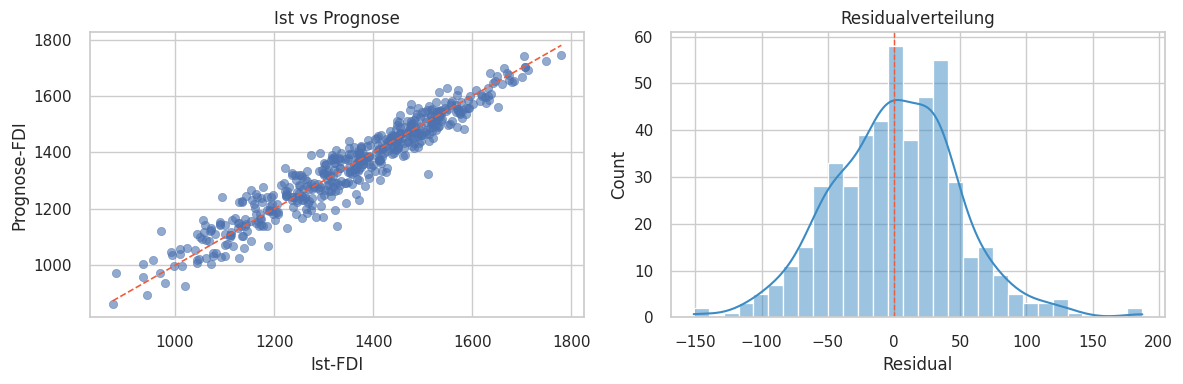

count    496.000000
mean       1.277513
std       47.957182
min     -151.339013
25%      -31.985240
50%        1.379336
75%       31.797054
max      187.627343
Name: profile_fdi_rating, dtype: float64

In [58]:
best_preds = best_pipeline.predict(X_test)
residuals = y_test - best_preds

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x=y_test, y=best_preds, ax=axes[0], alpha=0.6, edgecolor=None)
axes[0].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="#f05c3b",
    linestyle="--",
    linewidth=1.2,
)
axes[0].set_xlabel("Ist-FDI")
axes[0].set_ylabel("Prognose-FDI")
axes[0].set_title("Ist vs Prognose")

sns.histplot(residuals, bins=30, kde=True, ax=axes[1], color="#3b8bc4")
axes[1].axvline(0, color="#f05c3b", linestyle="--", linewidth=1.0)
axes[1].set_xlabel("Residual")
axes[1].set_title("Residualverteilung")
fig.tight_layout()
plt.show()

pd.Series(residuals).describe()

## Feature-Wichtigkeit

/tmp/ipykernel_23540/2009357770.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="abs_importance", y="feature", ax=ax, palette="viridis")


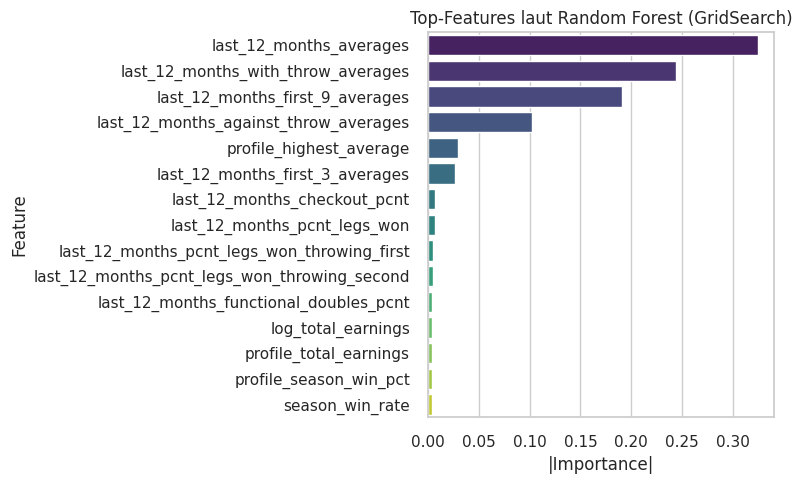

In [59]:
preprocessor = best_pipeline.named_steps["preprocess"]
feature_names = preprocessor.get_feature_names_out()
model = best_pipeline.named_steps["model"]

if hasattr(model, "coef_"):
    importances = model.coef_
elif hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
else:
    importances = None

if importances is None:
    print("Feature-Wichtigkeit nicht verfuegbar.")
else:
    importance_df = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
        .assign(abs_importance=lambda d: d["importance"].abs())
        .sort_values("abs_importance", ascending=False)
        .head(15)
    )
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=importance_df, x="abs_importance", y="feature", ax=ax, palette="viridis")
    ax.set_xlabel("|Importance|")
    ax.set_ylabel("Feature")
    ax.set_title(f"Top-Features laut {best_model_name}")
    fig.tight_layout()
    plt.show()
    importance_df

## Fazit

- Das Notebook identifiziert automatisch das leistungsstaerkste Modell via Test-R2 und speichert es als `best_pipeline` fuer weitere Schritte (z.B. Deployment in Streamlit).
- Lineare Basis-Modelle liefern nachvollziehbare Koeffizienten, regulierte Varianten reduzieren Varianz, und Random Forests bilden Nichtlinearitaeten ab.
- Residuenplots und Feature-Wichtigkeiten pruefen Modellannahmen und liefern inhaltliche Einsichten zu Hard- und Soft-Facts.
- Naechste Schritte: Hyperparameter-Tuning (GridSearchCV), zeitliche Validierung, sowie Export der Pipeline inkl. Modellartefakt.